In [ ]:
# Dependencies
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
import os

In [16]:
cpus = tf.config.experimental.list_physical_devices('CPU')
len(cpus)

1

# Data Setup

In [19]:
# Remove corrupted or non-acceptable extensions

In [35]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [26]:
data_dir = 'data/train'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
# Check all covid pictures
# os.listdir(os.path.join(data_dir, 'covid'))

In [33]:
# Read image as a numpy array
img = cv2.imread(os.path.join('data/train', 'covid', '02.jpeg'))
img.shape

(3480, 4248, 3)

In [ ]:
# 3480 pixels high x 4248 pixels wide with 3 channels (colored image

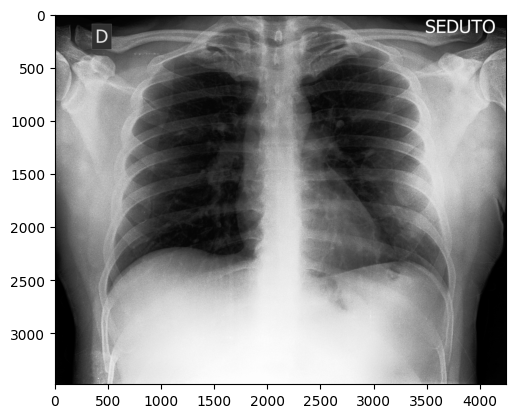

In [45]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [46]:
## Remove any incompatible images (in case dataset is extracted from Google searches or similar
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))

# Load Data

In [48]:
import numpy as np

In [52]:
# Build dataset with classes on the fly with Keras
data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 181 files belonging to 2 classes.


In [55]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()